Linear Regression model to forecast Carbon Intensity

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the PROCESSED data (not the original combined data!)
df = pd.read_csv("processed_data.csv")  # This is the key change!

# Load the scaler 
scaler = joblib.load('standard_scaler.pkl')

print(f"Processed data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check if target column exists
if 'Carbon_intensity_gCO₂eq_kWh_direct' in df.columns:
    print("✅ Target column found!")
else:
    print("❌ Target column missing")

Processed data shape: (175320, 25)
Columns: ['Datetime_UTC', 'Country', 'Zone_name', 'Zone_id', 'Carbon_intensity_gCO₂eq_kWh_direct', 'Carbon_intensity_gCO₂eq_kWh_Life_cycle', 'Carbon-free_energy_percentage_CFE%', 'Renewable_energy_percentage_RE%', 'Data_source', 'Data_estimated', 'Data_estimation_method', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'Season', 'TimeOfDay', 'Carbon_Efficiency', 'Clean_Energy_Gap', 'Zone_encoded', 'Carbon_Intensity_MA_24h', 'RE_Percentage_MA_24h']
✅ Target column found!


In [5]:
# Prepare features and target
feature_cols = [
    'Hour', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Zone_encoded',
    'Renewable_energy_percentage_RE%', 'Carbon-free_energy_percentage_CFE%',
    'Carbon_Efficiency', 'Clean_Energy_Gap', 
    'Carbon_Intensity_MA_24h', 'RE_Percentage_MA_24h'
]

# Filter only existing columns
feature_cols = [col for col in feature_cols if col in df.columns]

# Prepare X and y
X = df[feature_cols].fillna(0)
y = df['Carbon_intensity_gCO₂eq_kWh_direct']

print(f"Features used: {feature_cols}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Features used: ['Hour', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Zone_encoded', 'Renewable_energy_percentage_RE%', 'Carbon-free_energy_percentage_CFE%', 'Carbon_Efficiency', 'Clean_Energy_Gap', 'Carbon_Intensity_MA_24h', 'RE_Percentage_MA_24h']
Feature matrix shape: (175320, 12)
Target variable shape: (175320,)


In [6]:
# Train-test split (time-based to avoid data leakage)
split_idx = int(0.8 * len(X))

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (140256, 12)
Test set: (35064, 12)


In [7]:
# The numerical features are already scaled in the processed data!
# But we need to identify which ones to potentially re-scale if needed
numerical_cols = [
    'Renewable_energy_percentage_RE%', 'Carbon-free_energy_percentage_CFE%',
    'Carbon_Efficiency', 'Clean_Energy_Gap', 
    'Carbon_Intensity_MA_24h', 'RE_Percentage_MA_24h'
]

# Use the data as-is since it's already scaled
X_train_final = X_train
X_test_final = X_test

print("Using preprocessed scaled data directly")

Using preprocessed scaled data directly


In [8]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train)

print("✅ Linear Regression model trained successfully!")

✅ Linear Regression model trained successfully!


In [9]:
# Make predictions
y_pred_train = lr_model.predict(X_train_final)
y_pred_test = lr_model.predict(X_test_final)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

# Display results
print("="*60)
print("🔮 LINEAR REGRESSION - CARBON INTENSITY FORECASTING")
print("="*60)
print(f"Training Metrics:")
print(f"  MAE:  {train_mae:.4f} gCO₂eq/kWh")
print(f"  RMSE: {train_rmse:.4f} gCO₂eq/kWh")
print(f"  R²:   {train_r2:.4f}")
print(f"\nTest Metrics:")
print(f"  MAE:  {test_mae:.4f} gCO₂eq/kWh")
print(f"  RMSE: {test_rmse:.4f} gCO₂eq/kWh")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

🔮 LINEAR REGRESSION - CARBON INTENSITY FORECASTING
Training Metrics:
  MAE:  0.0285 gCO₂eq/kWh
  RMSE: 0.0404 gCO₂eq/kWh
  R²:   0.9982

Test Metrics:
  MAE:  0.0578 gCO₂eq/kWh
  RMSE: 0.0606 gCO₂eq/kWh
  R²:   0.9735


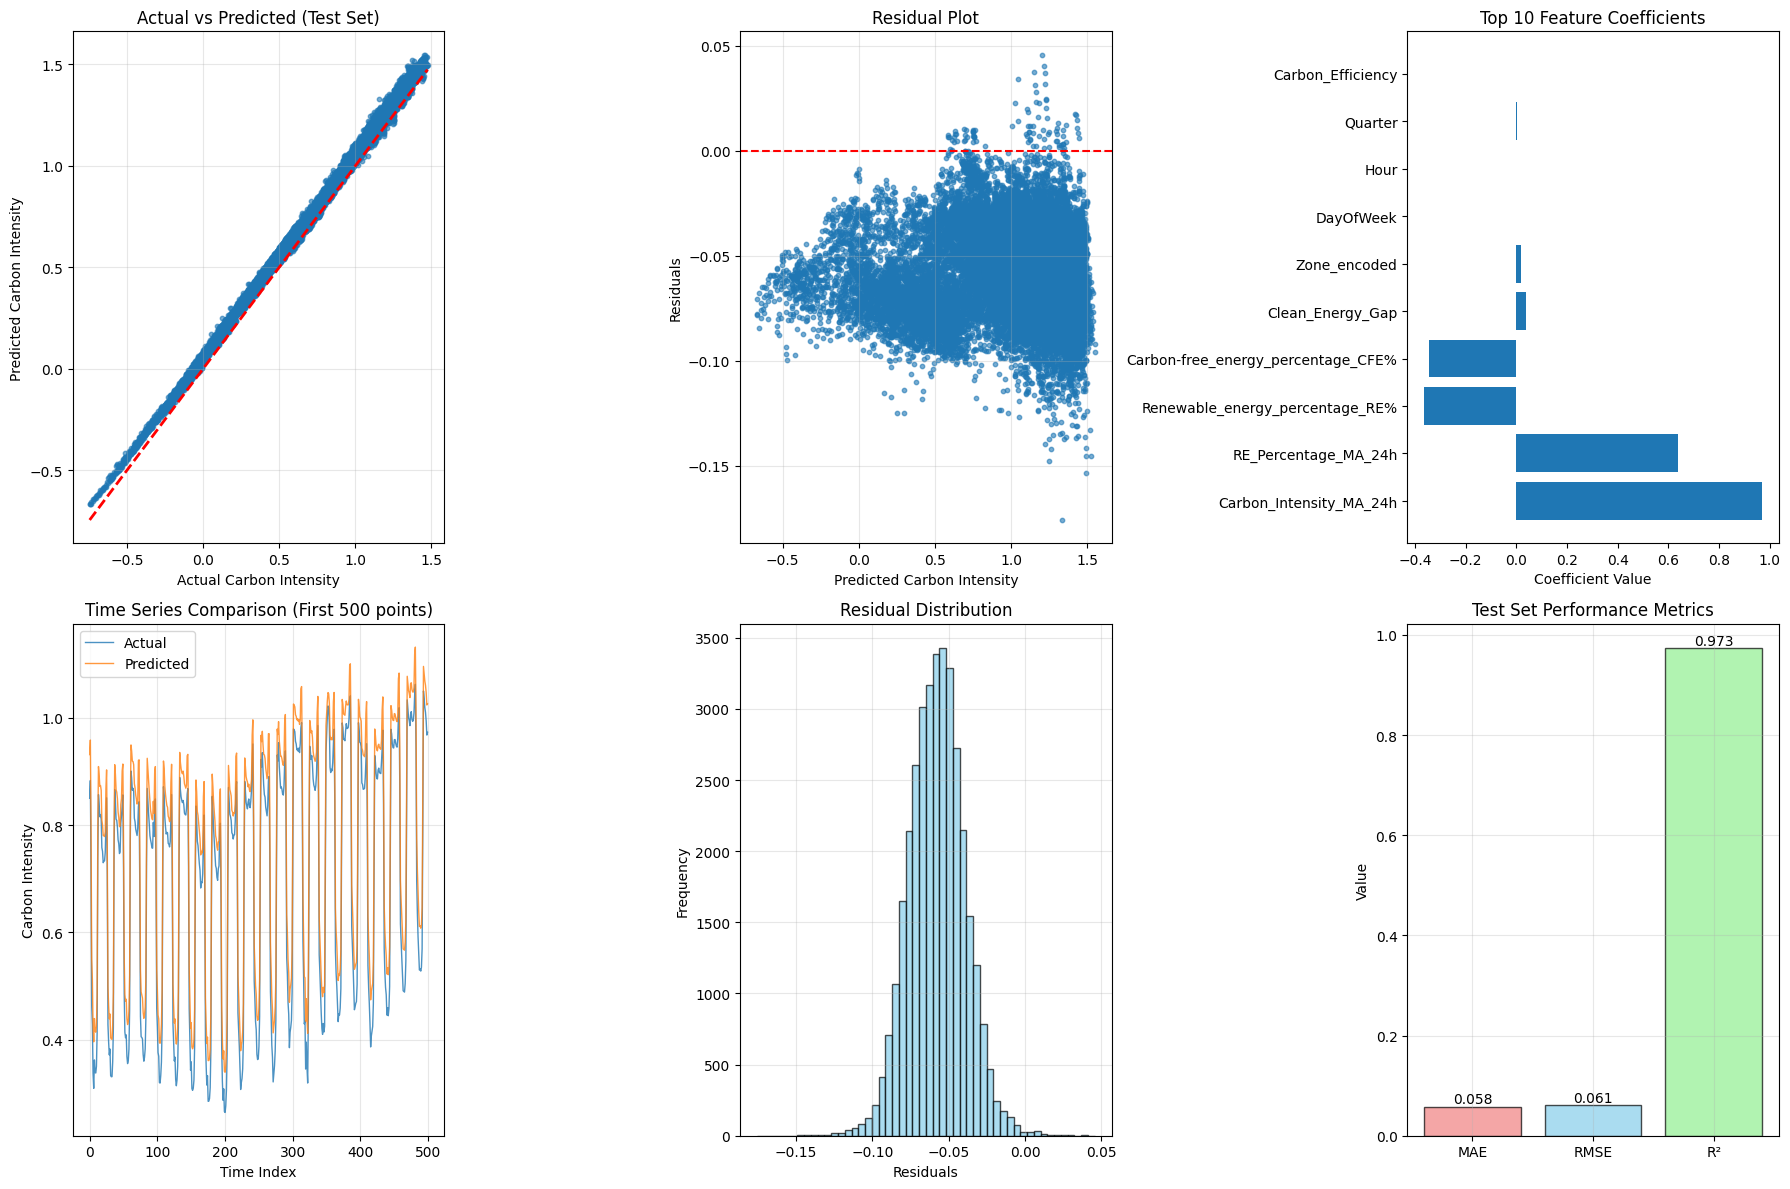

In [10]:
# Comprehensive Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.6, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Carbon Intensity')
axes[0, 0].set_ylabel('Predicted Carbon Intensity')
axes[0, 0].set_title('Actual vs Predicted (Test Set)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_pred_test
axes[0, 1].scatter(y_pred_test, residuals, alpha=0.6, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Carbon Intensity')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_
})
feature_importance = feature_importance.reindex(
    feature_importance.coefficient.abs().sort_values(ascending=False).index
)

axes[0, 2].barh(feature_importance['feature'][:10], feature_importance['coefficient'][:10])
axes[0, 2].set_xlabel('Coefficient Value')
axes[0, 2].set_title('Top 10 Feature Coefficients')

# 4. Prediction time series (sample)
sample_size = 500
axes[1, 0].plot(y_test.iloc[:sample_size].values, label='Actual', alpha=0.8, linewidth=1)
axes[1, 0].plot(y_pred_test[:sample_size], label='Predicted', alpha=0.8, linewidth=1)
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Carbon Intensity')
axes[1, 0].set_title(f'Time Series Comparison (First {sample_size} points)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Error distribution
axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

# 6. Model performance metrics bar chart
metrics = ['MAE', 'RMSE', 'R²']
values = [test_mae, test_rmse, test_r2]
colors = ['lightcoral', 'skyblue', 'lightgreen']

bars = axes[1, 2].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Test Set Performance Metrics')
axes[1, 2].set_ylabel('Value')
axes[1, 2].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [11]:
# Feature importance analysis
print("\n" + "="*60)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
})

feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
print(feature_importance.round(4))

print(f"\nIntercept: {lr_model.intercept_:.4f}")
print(f"\nMost influential features:")
print(f"1. {feature_importance.iloc[0]['Feature']}: {feature_importance.iloc[0]['Coefficient']:.4f}")
print(f"2. {feature_importance.iloc[1]['Feature']}: {feature_importance.iloc[1]['Coefficient']:.4f}")
print(f"3. {feature_importance.iloc[2]['Feature']}: {feature_importance.iloc[2]['Coefficient']:.4f}")


🔍 FEATURE IMPORTANCE ANALYSIS
                               Feature  Coefficient  Abs_Coefficient
10             Carbon_Intensity_MA_24h       0.9688           0.9688
11                RE_Percentage_MA_24h       0.6388           0.6388
6      Renewable_energy_percentage_RE%      -0.3634           0.3634
7   Carbon-free_energy_percentage_CFE%      -0.3456           0.3456
9                     Clean_Energy_Gap       0.0396           0.0396
5                         Zone_encoded       0.0202           0.0202
3                            DayOfWeek      -0.0022           0.0022
0                                 Hour      -0.0017           0.0017
4                              Quarter       0.0011           0.0011
8                    Carbon_Efficiency      -0.0003           0.0003
1                                Month       0.0002           0.0002
2                                  Day      -0.0000           0.0000

Intercept: -0.0105

Most influential features:
1. Carbon_Intensity_MA_2

In [12]:
# Save the model and results
joblib.dump(lr_model, 'linear_regression_model.pkl')

# Save comprehensive results
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_test,
    'residuals': residuals,
    'abs_error': np.abs(residuals)
})

# Add datetime for time series analysis (if available)
if 'Datetime_UTC' in df.columns:
    results_df['datetime'] = df['Datetime_UTC'].iloc[X_test.index]

results_df.to_csv('linear_regression_results.csv', index=False)

# Save model summary
model_summary = {
    'model_type': 'Linear Regression',
    'target_variable': 'Carbon_intensity_gCO₂eq_kWh_direct',
    'features_used': feature_cols,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'test_metrics': {
        'MAE': float(test_mae),
        'RMSE': float(test_rmse),
        'R²': float(test_r2)
    },
    'feature_importance': feature_importance.to_dict('records')
}

import json
with open('linear_regression_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=2)

print("✅ Model saved as 'linear_regression_model.pkl'")
print("✅ Results saved as 'linear_regression_results.csv'")
print("✅ Summary saved as 'linear_regression_summary.json'")
print("\n🎯 Linear Regression baseline model completed!")

✅ Model saved as 'linear_regression_model.pkl'
✅ Results saved as 'linear_regression_results.csv'
✅ Summary saved as 'linear_regression_summary.json'

🎯 Linear Regression baseline model completed!
